Ben Ghertner 2025 (really this code was mostly written by chatGPT...)

Generates a figure of the weak solution regions in chapter 5

    - Figure 5.1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import PathPatch
from matplotlib.path import Path

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['text.usetex'] = True
plt.rcParams["font.size"] = 11

%matplotlib inline

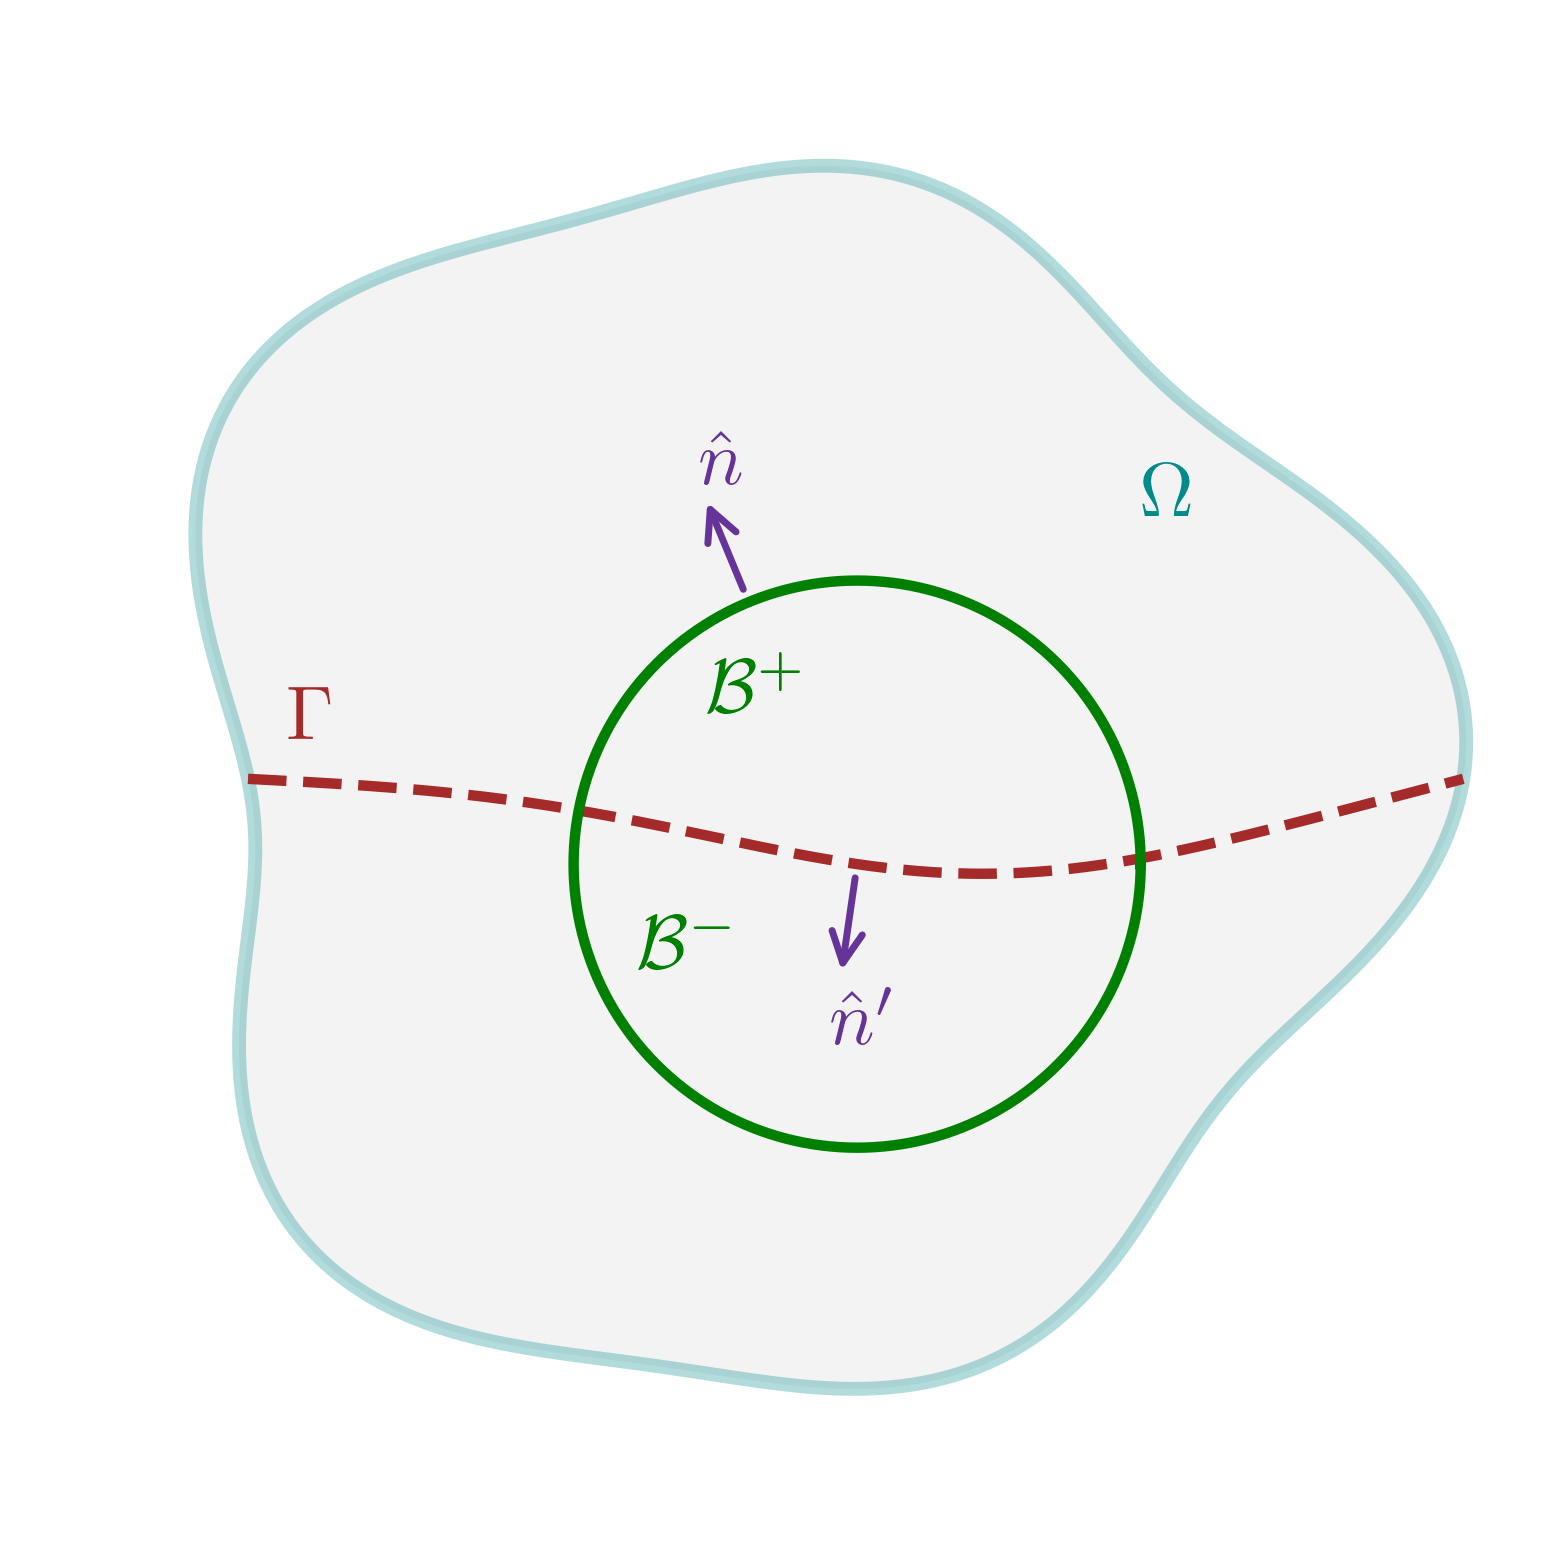

In [2]:
# ------------------------------------------------------------
# 1) Make a noncircular "blob" using a wobbly polar boundary
# ------------------------------------------------------------
np.random.seed(2)

# Angle parameter
npoints = 600
theta = np.linspace(0, 2*np.pi, npoints+1, endpoint=True)

# Radial shape: base radius + a few Fourier bumps (noncircular)
r = 1.5 + 0.1*np.cos(3*theta - 0.3) + 0.1*np.sin(5*theta + 1.2)

# Convert to Cartesian
x = r * np.cos(theta)
y = r * np.sin(theta)

# Ensure the polygon is closed
xy = np.column_stack((x, y))
codes = np.full(len(xy), Path.LINETO)
codes[0] = Path.MOVETO
blob_path = Path(xy, codes)

# ------------------------------------------------------------
# 2) Create a smooth interior curve that splits the blob
#    We'll draw a sinusoidal "diameter-like" curve that lies inside
# ------------------------------------------------------------
# Param t in [0,1]
t = np.linspace(0, 1, 400)

# A centerline from left to right with a gentle waviness
x_split = x[npoints//2] + t*(x[0] - x[npoints//2])
y_split = (-0.3*np.sin(np.pi*t) + 0.1*np.sin(2*np.pi*t)) * (0.6 - 0.1*np.cos(2*np.pi*t))

# Optionally clip this curve to the blob's interior (not necessary for display;
# the chosen amplitudes keep it inside). If desired, you could test with blob_path.contains_points.

# ------------------------------------------------------------
# 3) Choose points and draw outward arrows
# ------------------------------------------------------------
# Helper: centroid of blob (approx. mean of boundary points)
centroid = xy.mean(axis=0)

# (a) Arrow from the blob boundary pointing 'outward':
# pick a visually good boundary point index
idx = 250
p_edge = xy[idx]
# Outward direction approximated by vector from centroid to boundary point
dir_edge = p_edge - centroid
dir_edge = dir_edge / np.linalg.norm(dir_edge)
arrow_len_edge = 0.35
#p_edge -= dir_edge*0.05
p_edge_out = p_edge + arrow_len_edge*dir_edge

# (b) Arrow normal to the splitting curve:
# pick a mid-curve point
k = len(t)//2
p_curve = np.array([x_split[k], y_split[k]])

#Omega label point
idx2 = 60
p_edge_Om = xy[idx2]
dir_edge_Om = p_edge_Om - centroid
dir_edge_Om = dir_edge_Om / np.linalg.norm(dir_edge_Om)
p_Om = p_edge_Om - 0.3*dir_edge_Om

# Estimate tangent via finite difference, then normal by ±90° rotation
if 1 <= k < len(t)-1:
    tangent = np.array([x_split[k+1] - x_split[k-1], y_split[k+1] - y_split[k-1]])
else:
    tangent = np.array([x_split[min(k+1, len(t)-1)] - x_split[max(k-1, 0)],
                        y_split[min(k+1, len(t)-1)] - y_split[max(k-1, 0)]])

tangent = tangent / np.linalg.norm(tangent)
# Two possible normals: rotate ±90°. Choose the one that points away from centroid to look "outward-ish".
n1 = np.array([ -tangent[1],  tangent[0]])
n2 = np.array([  tangent[1], -tangent[0]])

# Pick normal that points more away from the centroid
cand = [n1, n2]
normals_dot = [np.dot(c, (p_curve - centroid)) for c in cand]
normal = cand[np.argmax(normals_dot)]
arrow_len_curve = 0.3
p_curve_out = p_curve + arrow_len_curve*normal

# ------------------------------------------------------------
# 4) Plot everything
# ------------------------------------------------------------
fig, ax = plt.subplots(layout='constrained')
fig.set_dpi(500)
fig.set_size_inches(3,3)

# Blob patch (shaded + outlined)
patch = PathPatch(blob_path, facecolor='0.85', edgecolor='darkcyan', linewidth=2, alpha=0.3)
ax.add_patch(patch)

# Splitting curve
ax.plot(x_split, y_split, ls='--', color='brown')

#   From splitting curve (normal/outward-ish)
ax.annotate(
    "", xy=p_curve_out, xytext=p_curve,
    arrowprops=dict(arrowstyle="->", lw=1, color='rebeccapurple')
)
# label offset a touch along the same normal
ax.text(*(p_curve_out + 0.15*normal), r"$\hat{n}'$", color='rebeccapurple')

ax.text(*(p_Om), r"$\Omega$", color='darkcyan')

ax.text(x[npoints//2] + 0.1, y[npoints//2] + 0.1, r"$\Gamma$", color='brown')

#Draw a circle around the n'
R = 0.7
xB = p_curve[0] + R*np.cos(theta)
yB = p_curve[1] + R*np.sin(theta)
ax.plot(xB, yB, color='green')

ax.text(p_curve[0] + 3*R/4*np.cos(3*np.pi/4), p_curve[1] + 3*R/4*np.sin(3*np.pi/4), r"$\mathcal{B}^+$", color='green')
ax.text(p_curve[0] + 6*R/7*np.cos(6*np.pi/7), p_curve[1] - 6*R/7*np.sin(6*np.pi/7), r"$\mathcal{B}^-$", color='green')

# Arrows:
#   From region boundary (outward)
ax.annotate(
    "", xy=(p_curve[0] + R*np.cos(2.5*np.pi/4)*1.43, p_curve[1] + R*np.sin(2.5*np.pi/4)*1.43), 
    xytext=(p_curve[0] + R*np.cos(2.5*np.pi/4), p_curve[1] + R*np.sin(2.5*np.pi/4)),
    arrowprops=dict(arrowstyle="->", lw=1, color='rebeccapurple')
)
ax.text(*(p_curve[0] + R*np.cos(2.5*np.pi/4)*1.45, p_curve[1] + R*np.sin(2.5*np.pi/4)*1.45),
         r"$\hat{n}$", color='rebeccapurple')


# Cosmetics
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(-1.8, 1.8)
ax.set_ylim(-1.8, 1.8)
ax.axis('off')

plt.show()